In [10]:
import pandas as pd
import matplotlib.pyplot as plt

In [1]:
import spacy
nlp = spacy.load('en_vectors_web_lg')

OSError: Can't find model 'en_vectors_web_lg'

In [12]:
RECORDS = -1  # -1 means 'load all'
COLUMN = 'Text'
MAX_WORDS_IN_SENTENCE = 200

In [14]:
from src import FineFoodReviewsDataSet
from IPython.display import display

dataset = FineFoodReviewsDataSet.load_data('../data/fine_foods_reviews.sqlite', limit=RECORDS, text_column=COLUMN)
train, test = dataset.train_test_split()
display(train.head())
display(test.head())

,Score,Text
191966,5,i love this gum and it is hard to find. when ...
378545,4,****<br />tazo's passion herbal infusion is a ...
58917,5,the baby sardines or sardinillas as they're ca...
128094,5,i tried this product with a stir fry my spouse...
113082,5,"3 words delicious, delicious, delicious! no fu..."


,Score,Text
103363,5,we had pretty much given up on gf pasta until ...
39025,5,i bought my first sproutmaster years ago at th...
237445,5,"for bold coffee fans like us, this is absolute..."
415521,4,"first impression: the friendly folks over at ""..."
272872,5,these things are awesome! i only ordered them...


In [16]:
display(train.describe())
display(test.describe())

,Score
count,394360.000000
mean,4.279235
std,1.317332
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


,Score
count,131454.000000
mean,4.278888
std,1.314910
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [7]:
from src import apply_middlewares, middleware


def apply_common_middleware(dataset, padding_length=200):
    clear_text_middleware = middleware.ClearTextMiddleware()
    binarize_labels_middleware = middleware.BinarizeLabelsMiddleware(threshold=3)
    nlp_middleware = middleware.WordsToNlpIndexMiddleware(nlp)
    input_middleware = middleware.NlpIndexToInputVectorMiddleware(nlp, padding_length=padding_length)
    cache_middleware = middleware.CacheMiddleware('../dist/data')

    return apply_middlewares(dataset, [
        clear_text_middleware,
        binarize_labels_middleware,
        nlp_middleware,
        cache_middleware,
        input_middleware
    ])


# middleware for data processing, caching etc
train = apply_common_middleware(train, padding_length=MAX_WORDS_IN_SENTENCE)
test = apply_common_middleware(test, padding_length=MAX_WORDS_IN_SENTENCE)


n_train_batches, train_generator = train.to_generator(batch_size=128)
n_test_batches, test_generator = test.to_generator(batch_size=128)

In [5]:
from keras.layers import Dense, Conv1D, BatchNormalization, GlobalMaxPooling1D, \
    Activation, Dropout, MaxPooling1D, Input, concatenate
from keras.models import Sequential 
from keras.regularizers import l2

def build_conv1d(max_len=MAX_WORDS_IN_SENTENCE, embedding_dim=300, filters=32, kernel_size=5, l2_weight=0.001,
                 dropout_rate=0.7):
    model = Sequential([
        Conv1D(
            filters, kernel_size, strides=1, kernel_regularizer=l2(l2_weight),
            input_shape=(max_len, embedding_dim), padding='valid', activation='relu'),
        MaxPooling1D(5),
        BatchNormalization(),
        Conv1D(
            2 * filters, kernel_size, strides=1, kernel_regularizer=l2(l2_weight),
            input_shape=(max_len, embedding_dim), padding='valid', activation='relu'),
        GlobalMaxPooling1D(),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(1, kernel_regularizer=l2(l2_weight)),
    ])
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model

In [6]:
model = build_conv1d()

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 196, 32)           48032     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 39, 32)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 39, 32)            128       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 64)            10304     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
__________

In [8]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=n_train_batches,
    epochs=5,
    verbose=1,
    validation_data=test_generator,
    validation_steps=n_test_batches)

Epoch 1/5
Data loaded from data_a198d0fc.h5
3081/3081 [==============================] - 139s 45ms/step - loss: 0.5082 - acc: 0.7662 - val_loss: 0.1520 - val_acc: 0.8884
Epoch 2/5
3081/3081 [==============================] - 164s 53ms/step - loss: 0.1243 - acc: 0.8915 - val_loss: 0.0910 - val_acc: 0.9084
Epoch 3/5
3081/3081 [==============================] - 168s 55ms/step - loss: 0.0913 - acc: 0.8994 - val_loss: 0.0854 - val_acc: 0.9110
Epoch 4/5
3081/3081 [==============================] - 164s 53ms/step - loss: 0.0902 - acc: 0.8990 - val_loss: 0.0851 - val_acc: 0.9092
Epoch 5/5
3081/3081 [==============================] - 167s 54ms/step - loss: 0.0888 - acc: 0.8993 - val_loss: 0.0821 - val_acc: 0.9086


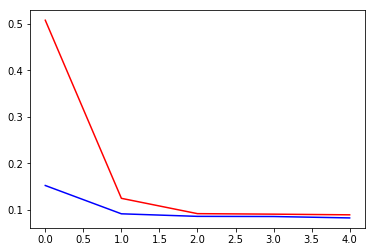

In [9]:
plt.plot(history.history['loss'], c='red')
_ = plt.plot(history.history['val_loss'], c='blue')

In [4]:
import os
filename = 'model_conv1d.h5'
filepath = os.path.join('../dist/models', filename)

In [ ]:
model.save(filepath)

In [6]:
from keras.models import load_model
model = load_model(filepath)

In [ ]:
model.predict([
    
])

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))